In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # For saving the model
from scipy.stats import randint

In [2]:
df = pd.read_csv('../data/proccessed/df_woe.csv')
df = df.drop(columns=['TransactionId','SubscriptionId','AccountId','ProductId','BatchId',
                      'CustomerId','CurrencyCode','CountryCode','TransactionStartTime',
                     ])
print(df.columns)

Index(['Amount', 'ChannelId', 'Value', 'FraudResult', 'PricingStrategy',
       'RFMS_Score', 'ProviderId', 'RiskLabel', 'ProductCategory',
       'Recency_woe', 'Seniority_woe', 'Monetary_woe', 'Frequency_woe'],
      dtype='object')


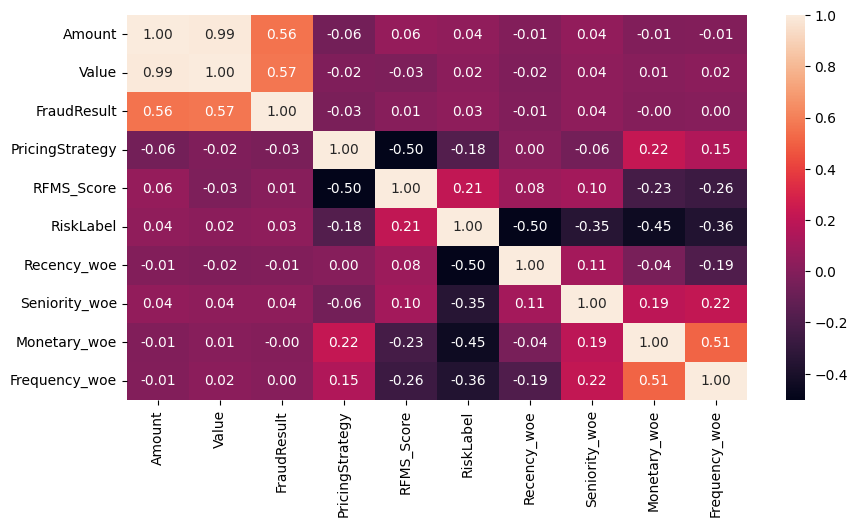

In [3]:
label_encoder = LabelEncoder()
# Fit and transform the RiskLabel column
df['RiskLabel'] = label_encoder.fit_transform(df['RiskLabel'])

plt.figure(figsize=(10, 5))
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

In [4]:
df = df.drop(columns=['Amount','RFMS_Score'])
print(df.columns)

Index(['ChannelId', 'Value', 'FraudResult', 'PricingStrategy', 'ProviderId',
       'RiskLabel', 'ProductCategory', 'Recency_woe', 'Seniority_woe',
       'Monetary_woe', 'Frequency_woe'],
      dtype='object')


In [5]:
# 1. Identify and encode categorical features (excluding target)
X = df.drop(columns=['RiskLabel'])  # Features
categorical_cols = X.select_dtypes(include=['object']).columns

# Use LabelEncoder or pd.get_dummies (simplest way: get_dummies)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 2. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 3. Prepare target variable
y = df['RiskLabel']  # Already encoded with LabelEncoder as in previous cell

# 4. Logistic Regression with L1 penalty (Lasso)
lasso = LogisticRegression(penalty='l1', solver='liblinear')  # L1 regularization
lasso.fit(X_scaled, y)

# 5. Extract non-zero coefficients
coef = pd.Series(lasso.coef_[0], index=X_encoded.columns)
selected_features_lasso = coef[coef != 0].index

print("Selected Features using Lasso Regression:")
print(selected_features_lasso)

Selected Features using Lasso Regression:
Index(['Value', 'FraudResult', 'PricingStrategy', 'Recency_woe',
       'Seniority_woe', 'Monetary_woe', 'Frequency_woe',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_5', 'ProviderId_ProviderId_2',
       'ProviderId_ProviderId_3', 'ProviderId_ProviderId_4',
       'ProviderId_ProviderId_5', 'ProviderId_ProviderId_6',
       'ProductCategory_data_bundles', 'ProductCategory_financial_services',
       'ProductCategory_movies', 'ProductCategory_other',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill'],
      dtype='object')


In [6]:
# Use selected features from encoded feature set
X_selected = X_encoded[selected_features_lasso]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)

# Random Forest Parameter Grid
rf_param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
# Gradient Boosting Parameter Grid
gbm_param_grid = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Search for Gradient Boosting
gbm_random_search = RandomizedSearchCV(estimator=gbm_model, param_distributions=gbm_param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, verbose=2)
gbm_random_search.fit(X_train, y_train)

print("Best GBM Parameters:", gbm_random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GBM Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}


In [ ]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return roc_auc

In [ ]:
# Evaluate Random Forest
print("Random Forest Performance:")
rf_roc_auc = evaluate_model(rf_grid_search, X_test, y_test)
# Evaluate Gradient Boosting
print("\nGradient Boosting Performance:")
gbm_roc_auc = evaluate_model(gbm_random_search, X_test, y_test)

Random Forest Performance:


NameError: name 'rf_grid_search' is not defined

In [ ]:
cv_scores_rf = cross_val_score(rf_grid_search, X_selected, y, cv=5)
cv_scores_gbm = cross_val_score(gbm_random_search, X_selected, y, cv=5)

print("\nRandom Forest CV Average Score:", cv_scores_rf.mean())
print("GBM CV Average Score:", cv_scores_gbm.mean())

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1051, in fit
    self._run_search(evaluate_candidates)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1605, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1028, in evaluate_candidates
    _warn_or_raise_about_fit_failures(out, self.error_score)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 505, in _warn_or_raise_about_fit_failures
    raise ValueError(all_fits_failed_message)
ValueError: 
All the 405 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Python313\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<5 lines>...
        ensure_all_finite=False,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Python313\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\michael\AppData\Roaming\Python\Python313\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'ChannelId_3'


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1051, in fit
    self._run_search(evaluate_candidates)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1605, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_search.py", line 1028, in evaluate_candidates
    _warn_or_raise_about_fit_failures(out, self.error_score)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 505, in _warn_or_raise_about_fit_failures
    raise ValueError(all_fits_failed_message)
ValueError: 
All the 405 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Python313\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<5 lines>...
        ensure_all_finite=False,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Python313\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\michael\AppData\Roaming\Python\Python313\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'ChannelId_2'

--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Python313\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<5 lines>...
        ensure_all_finite=False,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Python313\Lib\site-packages\sklearn\utils\_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\michael\AppData\Roaming\Python\Python313\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'ChannelId_3'



In [ ]:
# Plot ROC Curve for all three models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_grid_search.predict_proba(X_test)[:, 1])
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, gbm_random_search.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot(fpr_gbm, tpr_gbm, label=f'Gradient Boosting (AUC = {gbm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the best Classifier to a .pkl file
with open('../data/proccessed/final_model.pkl', 'wb') as file:
    pickle.dump(rf_grid_search, file) 

print("best model saved as 'final_model.pkl'")